# Análise de maré do modelo Delft3D: vento + maré


Comparação com `2022-Maregrafos_EPAGRI/waterlevel_sul_da_ilha.csv`.

Download to arquivo agregado e recortado para a área de estudo.

In [1]:
import pooch


url = f"https://github.com/LaPoGeoMar/Proj_Modelagem_Pellet/releases/download"
version = "v0.1.0"

fname = pooch.retrieve(
    url=f"{url}/{version}/model_tides_and_wind.nc4",
    known_hash="sha256:f3c5fd95ccffb9baea40aa431f6e0946cb2f49ea07274083e5d704e8099ea4c6",
)

Esse arquivo contém apenas velocidade superficial e altura do nível do mar.

In [2]:
import cf_xarray
import xarray as xr


ds = xr.open_dataset(fname)
ds

<xarray.Dataset>
Dimensions:     (time: 9517, m: 138, n: 218)
Coordinates:
    Layer       float32 ...
    latitude    (m, n) float32 ...
    longitude   (m, n) float32 ...
  * m           (m) float32 -48.87 -48.87 -48.86 -48.85 ... -47.53 -47.52 -47.51
  * n           (n) float32 -28.62 -28.62 -28.61 -28.6 ... -26.48 -26.47 -26.47
  * time        (time) datetime64[ns] 2021-01-01 ... 2022-02-01
Data variables:
    waterlevel  (time, m, n) float32 ...
    velocity_x  (time, m, n) float32 ...
    velocity_y  (time, m, n) float32 ...
Attributes: (12/25)
    title:                         NetCDF created from NEFIS-file trim-sc_fl_...
    institution:                   
    source:                        Delft3D trim file
    history:                       Mon Aug 22 14:21:18 2022: ncks -4 -L 1 jan...
    references:                    http://svn.oss.deltares.nl
    email:                         
    ...                            ...
    geospatial_lon_units:          dergees_east
    geospatial_vertical_min:       2.2039968967437744
    geospatial_vertical_max:       547.0967407226562
    geospatial_vertical_units:     m
    geospatial_vertical_positive:  down
    NCO:                           netCDF Operators version 5.1.0 (Homepage =...

Creio que os dados que temos é de um marégrafo no sul da Ilha nesse ponto.

In [3]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER


def creat_map(projection=ccrs.PlateCarree(), figsize=(4, 4), bbox=None):
    fig, ax = plt.subplots(
        figsize=figsize,
        subplot_kw={
            "projection": projection,
        }
    )
    if bbox:
        ax.set_extent(bbox)
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels = gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return fig, ax

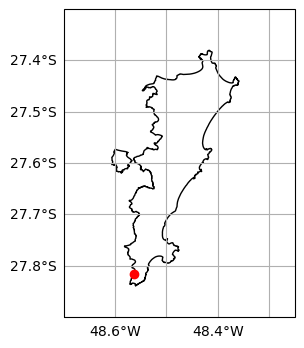

In [4]:
import geopandas


gdf = geopandas.read_file("data/floripa.geojson")
geom = gdf["geometry"].squeeze()


fig, ax = creat_map()

sul_da_ilha = -48.5639, -27.8161
ax.add_geometries([geom], ccrs.PlateCarree(), edgecolor="black", facecolor="none")
ax.set_extent([-48.7, -48.25, -27.9, -27.3])
ax.plot(sul_da_ilha[0], sul_da_ilha[1], "ro", label="Sul da Ilha");

A figura abaixo é só uma checada rápida do campo de velocidade em um passo de tempo.

In [5]:
import numpy as np


def normalize_speed(u, v):
    u_norm = u / np.sqrt(u ** 2.0 + v ** 2.0)
    v_norm = v / np.sqrt(u ** 2.0 + v ** 2.0)
    speed = (u ** 2 + v ** 2) ** 0.5
    return (u_norm, v_norm, speed)

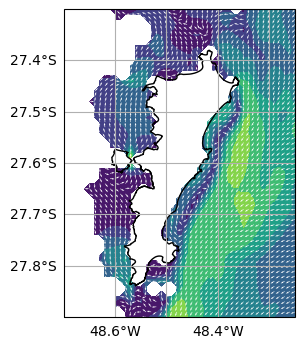

In [6]:
# %matplotlib notebook
import geopandas


gdf = geopandas.read_file("data/floripa.geojson")
geom = gdf["geometry"].squeeze()

subset = ds.sel({"time": "2021-01-01T00:00:00"})

bbox = subset["m"].min(), subset["m"].max(), subset["n"].min(), subset["n"].max()
bbox = [v.to_numpy() for v in bbox]


u = subset.cf["eastward_sea_water_velocity"].squeeze()
v = subset.cf["northward_sea_water_velocity"].squeeze()

u_norm, v_norm, speed = normalize_speed(u, v)

fig, ax = creat_map(bbox=bbox)
ax.contourf(subset["longitude"], subset["latitude"], speed)

ax.add_geometries([geom], ccrs.PlateCarree(), edgecolor="black", facecolor="none")
ax.set_extent([-48.7, -48.25, -27.9, -27.3])
ax.quiver(subset["longitude"], subset["latitude"], u_norm, v_norm, color="white", scale=50);

Vamos tentar pegar o ponto do modelo mais próximo do marégrafo.

In [7]:
import xoak


# sklearn_geo_balltree would be better than scipy_kdtree but it doesn't accept NaNsseries
ds.xoak.set_index(["latitude", "longitude"], "scipy_kdtree")

In [8]:
point = xr.Dataset({
    "longitude": ("point", [sul_da_ilha[0]]),
    "latitude": ("point", [sul_da_ilha[1]]),
})


model_series = ds.xoak.sel(
    longitude=point["longitude"],
    latitude=point["latitude"],
)

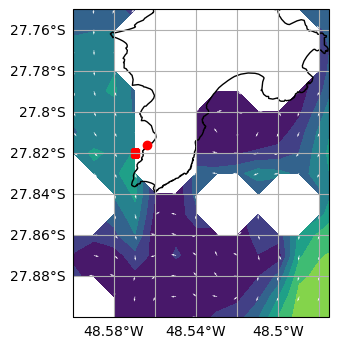

In [9]:
fig, ax = creat_map(bbox=bbox)
ax.contourf(subset["longitude"], subset["latitude"], speed)
ax.quiver(subset["longitude"], subset["latitude"], u_norm, v_norm, color="white", scale=50);

ax.plot(sul_da_ilha[0], sul_da_ilha[1], "ro", label="")
ax.plot(model_series["longitude"], model_series["latitude"], "rs", label="Sul da Ilha-Modelo");

ax.add_geometries([geom], ccrs.PlateCarree(), edgecolor="black", facecolor="none")
ax.set_extent([-48.6, -48.475, -27.9, -27.75])

Agora podemos extrair uma série temporal nesse ponto e comparar a maré com nossos dados.

In [10]:
cols = ["waterlevel", "velocity_x", "velocity_y", "time"]
df = model_series.to_dataframe().reset_index()
df = df[cols]
df = df.set_index("time")

In [11]:
import utide


coef = utide.solve(
    df.index,
    df["waterlevel"],
    lat=-27.82004,
    method="robust",
    conf_int="MC",
    verbose=False,
)

## Tabela com as constituintes de harmónicas

In [12]:
import pandas as pd


def table(coef):
    summary = pd.DataFrame(coef["diagn"])
    summary["frq"] = coef["aux"]["frq"]
    summary["A"] = coef["A"]
    summary["A_ci"] = coef["A_ci"]
    summary["g"] = coef["g"]
    summary["g_ci"] = coef["g_ci"]
    summary = summary.set_index("name")
    return summary.sort_values(by="A", ascending=False)

summary = table(coef)
summary.head(20)

,PE,SNR,frq,A,A_ci,g,g_ci
name,,,,,,,
M2,41.932479,1.565435e+06,0.080511,0.177245,0.000278,162.378947,0.082109
S2,20.694696,1.015779e+06,0.083333,0.124517,0.000242,161.808555,0.129889
O1,15.503581,5.947121e+05,0.038731,0.107774,0.000274,116.628724,0.188695
SA,8.464026,1.301794e+02,0.000114,0.079632,0.013680,134.528375,9.611564
K1,4.987426,1.468091e+05,0.041781,0.061127,0.000313,181.039278,0.293660
K2,1.816492,8.969868e+04,0.083561,0.036891,0.000241,155.967619,0.399178
SSA,1.663221,2.923868e+01,0.000228,0.035300,0.012795,148.008129,18.440564
N2,1.636061,7.298681e+04,0.078999,0.035010,0.000254,241.371259,0.365479
Q1,1.098890,3.227137e+04,0.037219,0.028693,0.000313,90.470251,0.796855


## Número de Forma da maré

In [13]:
def report_summary(summary):
    K1 = summary.loc["K1"]["A"]
    O1 = summary.loc["O1"]["A"]
    M2 = summary.loc["M2"]["A"]
    S2 = summary.loc["S2"]["A"]
    M4 = summary.loc["M4"]["A"]
    return (K1 + O1) / (M2 + S2)

report_summary(summary)

0.5597185589895204

Agora podemos reconstruir a maré e comparar com nossos dados.

In [14]:
tide = utide.reconstruct(df.index, coef, verbose=False)
df["prediction_model"] = tide["h"]
df["res"] = df["waterlevel"] - tide["h"]

In [15]:
from datetime import timedelta


sul = pd.read_csv("2022-Maregrafos_EPAGRI/waterlevel_sul_da_ilha.csv", index_col="datetime", parse_dates=True)
# Phase diff from model and observations.
sul.index = sul.index + timedelta(hours=3)

model = df[["prediction_model"]]

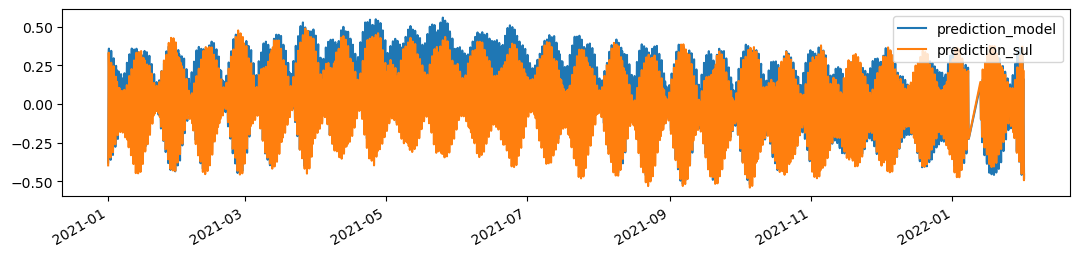

In [16]:
comp = pd.concat([model, sul]).resample("1H").mean().dropna()
ax = comp.plot(figsize=(13, 2.75))

https://github.com/SECOORA/skill_score/blob/master/notebooks/timeSeries/ssh/01-skill_score.ipynb

Raiz do erro médio quadrático e r2.

In [17]:
def rmse(obs, model):
    """
    Compute root mean square between the observed data (`obs`) and the modeled
    data (`model`).
    >>> obs = [3, -0.5, 2, 7]
    >>> model = [2.5, 0.0, 2, 8]
    >>> rmse(obs, model)
    0.61237243569579447
    >>> obs = [[0.5, 1],[-1, 1],[7, -6]]
    >>> model = [[0, 2],[-1, 2],[8, -5]]
    >>> rmse(obs, model)
    0.84162541153017323
    """
    from sklearn.metrics import mean_squared_error
    return np.sqrt(mean_squared_error(obs, model))


def r2(x, y):
    from sklearn.metrics import r2_score
    return r2_score(x, y)


rmse(
    obs=comp["prediction_sul"],
    model=comp["prediction_model"],
)

0.09077431230065035

In [18]:
r2(
    x=comp["prediction_sul"],
    y=comp["prediction_model"],
)

0.7610160207103276

Erro médio quadrático.

In [19]:
import sklearn



sklearn.metrics.mean_squared_error(
    y_true=comp["prediction_sul"],
    y_pred=comp["prediction_model"],
)

0.008239975773656

R de pearson.

In [20]:
from scipy.stats import pearsonr


pearsonr(
    x=comp["prediction_sul"],
    y=comp["prediction_model"],
)

PearsonRResult(statistic=0.9397163576655971, pvalue=0.0)

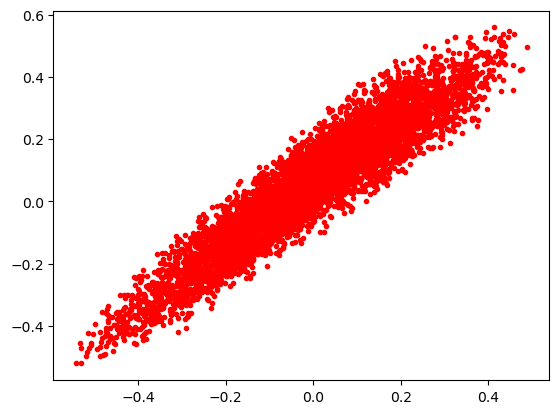

In [21]:
plt.plot(
    comp["prediction_sul"],
    comp["prediction_model"],
    "r."
);

Diagrama de Taylor

In [22]:
import numpy as np
import matplotlib.pyplot as plt



class TaylorDiagram(object):
    """
    Taylor diagram: plot model standard deviation and correlation
    to reference (data) sample in a single-quadrant polar plot, with
    r=stddev and theta=arccos(correlation).

    Taylor diagram (Taylor, 2001) test implementation.

    http://www-pcmdi.llnl.gov/about/staff/Taylor/CV/Taylor_diagram_primer.htm
    https://gist.github.com/ycopin/3342888

    """

    def __init__(self, refstd, fig=None, rect=111, label='_'):
        """
        Set up Taylor diagram axes, i.e. single quadrant polar
        plot, using mpl_toolkits.axisartist.floating_axes. refstd is
        the reference standard deviation to be compared to.

        """

        from matplotlib.projections import PolarAxes
        from mpl_toolkits.axisartist import floating_axes
        from mpl_toolkits.axisartist import grid_finder

        self.refstd = refstd  # Reference standard deviation.

        tr = PolarAxes.PolarTransform()

        # Correlation labels.
        rlocs = np.concatenate((np.arange(10)/10., [0.95, 0.99]))
        tlocs = np.arccos(rlocs)  # Conversion to polar angles.
        gl1 = grid_finder.FixedLocator(tlocs)  # Positions.
        dict_formatter = dict(list(zip(tlocs, map(str, rlocs))))
        tf1 = grid_finder.DictFormatter(dict_formatter)

        # Standard deviation axis extent.
        self.smin = 0
        self.smax = 1.5*self.refstd

        extremes = (0,
                    np.pi/2,  # 1st quadrant.
                    self.smin,
                    self.smax)
        ghelper = floating_axes.GridHelperCurveLinear(tr,
                                                      extremes=extremes,
                                                      grid_locator1=gl1,
                                                      tick_formatter1=tf1)

        if fig is None:
            fig = plt.figure()

        ax = floating_axes.FloatingSubplot(fig, rect, grid_helper=ghelper)
        fig.add_subplot(ax)

        # Adjust axes.
        ax.axis["top"].set_axis_direction("bottom")  # "Angle axis".
        ax.axis["top"].toggle(ticklabels=True, label=True)
        ax.axis["top"].major_ticklabels.set_axis_direction("top")
        ax.axis["top"].label.set_axis_direction("top")
        ax.axis["top"].label.set_text("Correlation")

        ax.axis["left"].set_axis_direction("bottom")  # "X axis".
        ax.axis["left"].label.set_text("Standard deviation")

        ax.axis["right"].set_axis_direction("top")  # "Y axis".
        ax.axis["right"].toggle(ticklabels=True)
        ax.axis["right"].major_ticklabels.set_axis_direction("left")

        ax.axis["bottom"].set_visible(False)  # Useless.

        # Contours along standard deviations.
        ax.grid(False)

        self._ax = ax  # Graphical axes.
        self.ax = ax.get_aux_axes(tr)  # Polar coordinates.

        # Add reference point and stddev contour.
        l, = self.ax.plot([0], self.refstd, 'ko',
                          ls='', ms=10, label=label)
        t = np.linspace(0, np.pi/2)
        r = np.zeros_like(t) + self.refstd
        self.ax.plot(t, r, 'k--', label='_')

        # Collect sample points for latter use (e.g. legend).
        self.samplePoints = [l]

    def add_sample(self, stddev, corrcoef, *args, **kwargs):
        """
        Add sample (stddev, corrcoeff) to the Taylor diagram. args
        and kwargs are directly propagated to the Figure.plot
        command.

        """
        l, = self.ax.plot(np.arccos(corrcoef), stddev,
                          *args, **kwargs)  # (theta, radius).
        self.samplePoints.append(l)
        return l

    def add_contours(self, levels=5, **kwargs):
        """
        Add constant centered RMS difference contours.

        """
        rs, ts = np.meshgrid(np.linspace(self.smin, self.smax),
                             np.linspace(0, np.pi/2))
        # Compute centered RMS difference.
        rms = np.sqrt(self.refstd**2 + rs**2 - 2*self.refstd*rs*np.cos(ts))
        contours = self.ax.contour(ts, rs, rms, levels, **kwargs)
        return contours

In [23]:
x = comp.index
obs = comp["prediction_sul"]
model = comp["prediction_model"]

refstd = obs.std(ddof=1)

samples = [[model.std(ddof=1), np.corrcoef(obs, model)[0, 1]]]

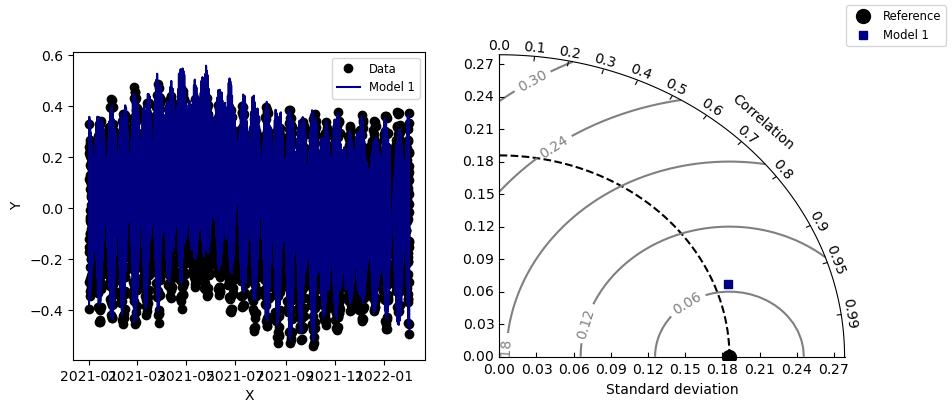

In [24]:
fig = plt.figure(figsize=(10, 4))

ax1 = fig.add_subplot(1, 2, 1, xlabel="X", ylabel="Y")
# Taylor diagram.
dia = TaylorDiagram(refstd, fig=fig, rect=122, label="Reference")

colors = plt.matplotlib.cm.jet(np.linspace(0, 1, len(samples)))

ax1.plot(x, obs, "ko", label="Data")
for k, m in enumerate([model]):
    ax1.plot(x, m, c=colors[k], label="Model %d" % (k+1))
ax1.legend(numpoints=1, prop=dict(size="small"), loc="best")

# Add samples to Taylor diagram.
for k, (stddev, corrcoef) in enumerate(samples):
    dia.add_sample(stddev, corrcoef, marker="s", ls="", c=colors[k],
                   label="Model %d" % (k+1))

# Add RMS contours, and label them.
contours = dia.add_contours(colors="0.5")
plt.clabel(contours, inline=1, fontsize=10)

# Add a figure legend.
fig.legend(dia.samplePoints,
           [p.get_label() for p in dia.samplePoints],
           numpoints=1, prop=dict(size="small"), loc="upper right");